# Word Embeddings with Gensim

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
from sklearn.decomposition import PCA

We will use [Gensim](https://radimrehurek.com/gensim/index.html), a package for topic modelling and text similarity, which now exposes some efficient implementations of word embeddings (Word2Vec, GloVe, fastText). This lab provides a first short peek into word embeddings: a much wider topic in itself.

### Pre-trained models

See here for pre-trained models and available datasets via Gensim: https://github.com/RaRe-Technologies/gensim-data.


For this example, refer to: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html.

In [2]:
# Load a pre-trained model
import gensim.downloader as api
wv = api.load('glove-wiki-gigaword-100') # Pre-trained model (just the word embeddings) from Wikipedia + Gigaworld
# WARNING: this is not the model we described in class, but GloVe (see optional contents)
# The dimension of these vectors is 100

In [4]:
# access the words
for i, word in enumerate(wv.vocab):
    if i == 20:
        break
    print(word)

the
,
.
of
to
and
in
a
"
's
for
-
that
on
is
was
said
with
he
as


In [5]:
# access the vectors
vec_king = wv['king']
print(vec_king)

[-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -0.98878

In [6]:
# an exception is raised for missing words
wv["kanliwg"]

KeyError: "word 'kanliwg' not in vocabulary"

In [7]:
# similarity queries (default to cosine similarity: 0 least similar, to 1 most similar)
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, wv.similarity(w1, w2)))

'car'	'minivan'	0.67
'car'	'bicycle'	0.69
'car'	'airplane'	0.65
'car'	'cereal'	0.12
'car'	'communism'	0.04


In [26]:
# do not trust me:
from scipy.spatial.distance import cosine

1 - cosine(wv["car"],wv["minivan"]) # note: Gensim computes similarities, here we have it as a distance, hence 1-similarity (when the score goes between 0 and 1)

0.6690627932548523

In [8]:
# you can also get a list

wv.most_similar("car")

[('vehicle', 0.8630838394165039),
 ('truck', 0.8597878217697144),
 ('cars', 0.837166965007782),
 ('driver', 0.8185911178588867),
 ('driving', 0.781263530254364),
 ('motorcycle', 0.7553157210350037),
 ('vehicles', 0.7462255954742432),
 ('parked', 0.7459464073181152),
 ('bus', 0.7372706532478333),
 ('taxi', 0.7155268788337708)]

In [63]:
# most dissimilar

wv.most_similar(negative=["car"])

[('jae-suk', 0.5536853671073914),
 ('ren?e', 0.5491408109664917),
 ('aelfric', 0.5432723760604858),
 ('wiek', 0.5375073552131653),
 ('zety', 0.5373221039772034),
 ('wenxue', 0.5362256765365601),
 ('zibi', 0.5342655181884766),
 ('taijutsu', 0.5330424308776855),
 ('anishinaabeg', 0.532688558101654),
 ('berte', 0.531627893447876)]

In [69]:
# finding "intruders"

print(wv.doesnt_match("breakfast car dinner lunch snack".split()))

car


#### Analogies

Another contribution of the Wird2Vec original paper was evaluation by analogy: if we sum two related word senses, and subtract a third, do we get what we intuitively should?

In [35]:
def analogy(x1, x2, x3):
    result = wv.most_similar(positive=[x1, x2], negative=[x3])
    return result[0][0]

In [38]:
analogy("king","woman","man")

'queen'

In [53]:
analogy("pasta","japan","italy")

'noodles'

In [61]:
analogy("japan","london","tokio")

'britain'

In [54]:
analogy("water","ice","liquid")

'snow'

### Training a model

https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model.

In [6]:
import gensim.downloader as api
text8_path = api.load('text8', return_path=True) # a slice of Wikipedia in English
text8_path

[==================================================] 100.0% 31.6/31.6MB downloaded


'/Users/giovannicolavizza/gensim-data/text8/text8.gz'

In [28]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Using params from Word2Vec_FastText_Comparison
params = {
    'size': 100, # dimension of embeddings
    'window': 5, # window -/+ before and after focus word
    'iter': 5, # number of iterations over the corpus
    'min_count': 5, # filter on words whose frequency is below this count
    'sg': 0, # use the skip-gram (1) or the CBOW (0) mode. In class, we presented the CBOW (predict context given focus words). See optional materials for the skip-gram (predict focus given context)
    'negative': 5, # how many negative samples to use (see optional class contents too)
    'workers': 4, # how many cores to use
    'alpha': 0.05 # initial learning rate for SGD. This is lambda in the class notes
}
model = Word2Vec(Text8Corpus(text8_path), **params)
print(model)

Word2Vec(vocab=71290, size=100, alpha=0.05)


In [55]:
# similarity queries (default to cosine similarity: 0 least similar, to 1 most similar)
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

'car'	'minivan'	0.44
'car'	'bicycle'	0.51
'car'	'airplane'	0.52
'car'	'cereal'	0.12
'car'	'communism'	-0.03


How to build an index for similarity queries: https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html.

### Visualization

From: http://web.stanford.edu/class/cs224n/.

We use Principal Component Analysis (PCA) to visualize vectors in high dimensions in 2d: https://en.wikipedia.org/wiki/Principal_component_analysis. PCA corresponds to doing an eigenvalue decomposition of the data correlation matrix, or an SVD of the data matrix (our word vectors). You can think of it as creating orthogonal and variance-maximizing linear combinations of features (the original embedding dimensions we have).

In [77]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    # do PCA on the selected embeddings
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

/anaconda3/envs/oxss/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


<IPython.core.display.Javascript object>


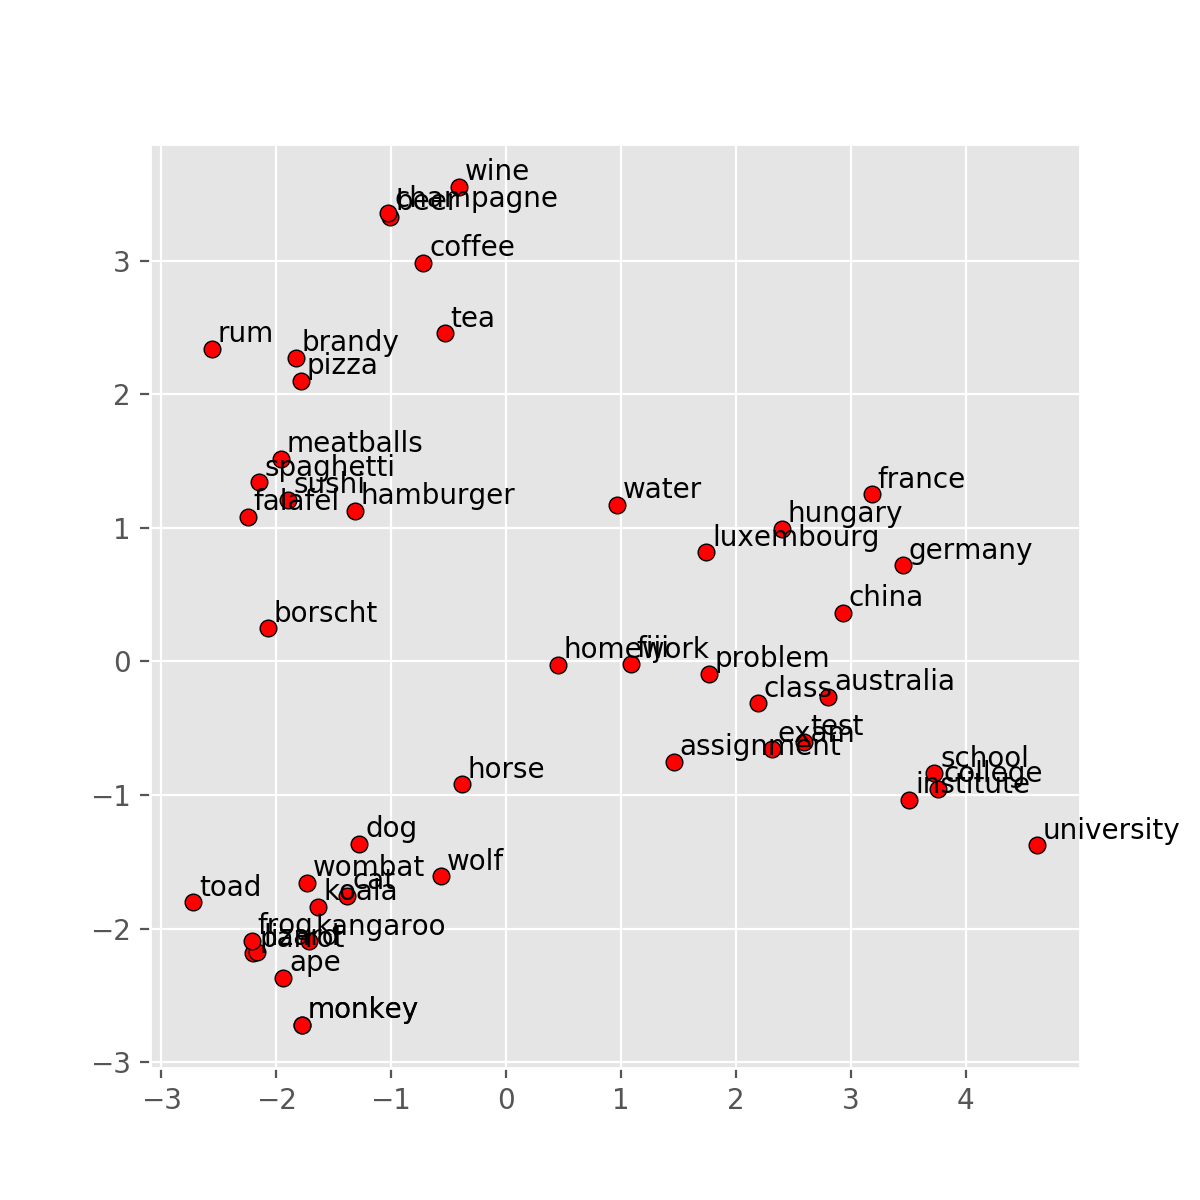

In [81]:
display_pca_scatterplot(wv, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

/anaconda3/envs/oxss/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


<IPython.core.display.Javascript object>


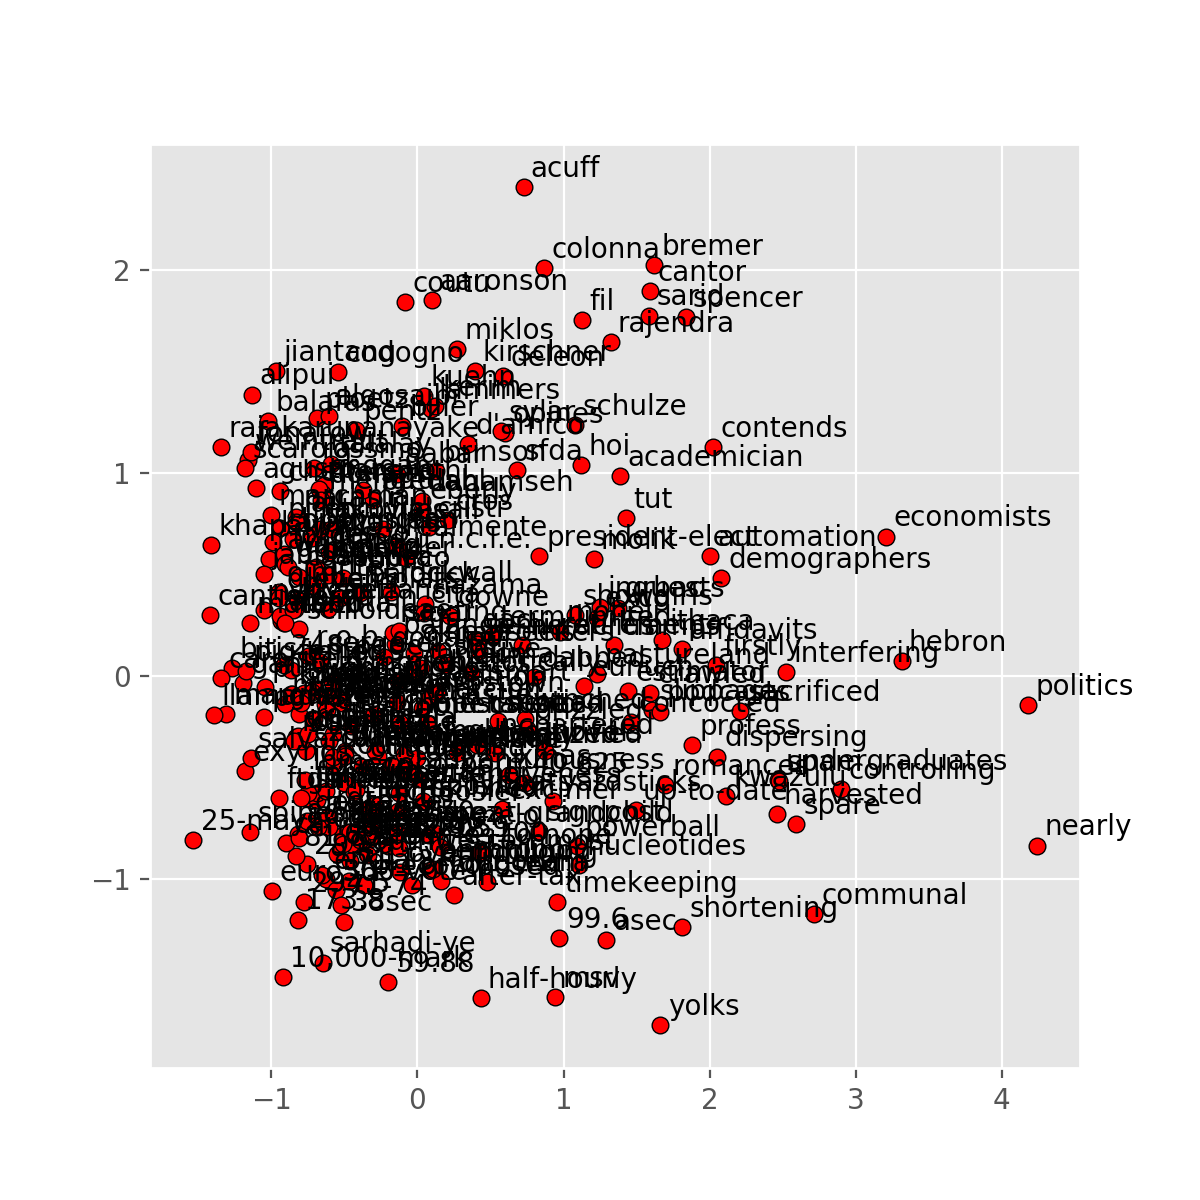

In [91]:
display_pca_scatterplot(wv, sample=300)

---

### Exercise

1. Train your own model in batches following the steps detailed here: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model. You could use, for example, the Brown or Reuters corpora from NLTK. Do the pre-processing which you deem useful.
2. Compare your Word2Vec results with a counting-based method from lab 8 or assignment 3, using the SimLex-999 dataset.

In [ ]:
# your code here